In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Dec 25 12:08:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 51%   84C    P2   219W / 250W |   3333MiB / 11019MiB |     92%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 500

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = '25December__DDplus_loss_Ba_iter5_floatAll_500epochs_3em6'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 3e-6

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(1)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## finished at training cost = 1.46, validation cost = 1.50
d_folder = '25December__DDplus_loss_Ba_iter3_floatAll_100epochs_3em6'
d_name = d_folder
suffix = 'final'
dict_name = 'ML/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)



output =  ML/25December__DDplus_loss_Ba_iter5_floatAll_500epochs_3em6
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc

<All keys matched successfully>

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
A[iTrk][0] =  312.1509
B[iTrk][0] =  312.14526
C[iTrk][0] =  0.018625624
D[iTrk][0] =  -0.003707775
E[iTrk][0] =  0.7585639
F[iTrk][0] =  1.5268729
A[iTrk][0] =  307.0049
B[iTrk][0] =  309.3697
C[iTrk][0] =  16.298458
D[iTrk][0] =  3.7850251
E[iTrk][0] =  39.0255
F[iTrk][0] =  -28.694317
A[iTrk][0] =  311.72607
B[iTrk][0] =  312.14993
C[iTrk][0] =  0.86016846
D[iTrk][0] =  0.03459918
E[iTrk][0] =  11.524924
F[iTrk][0] =  -0.93459
A[iTrk][0] 

<IPython.core.display.Javascript object>


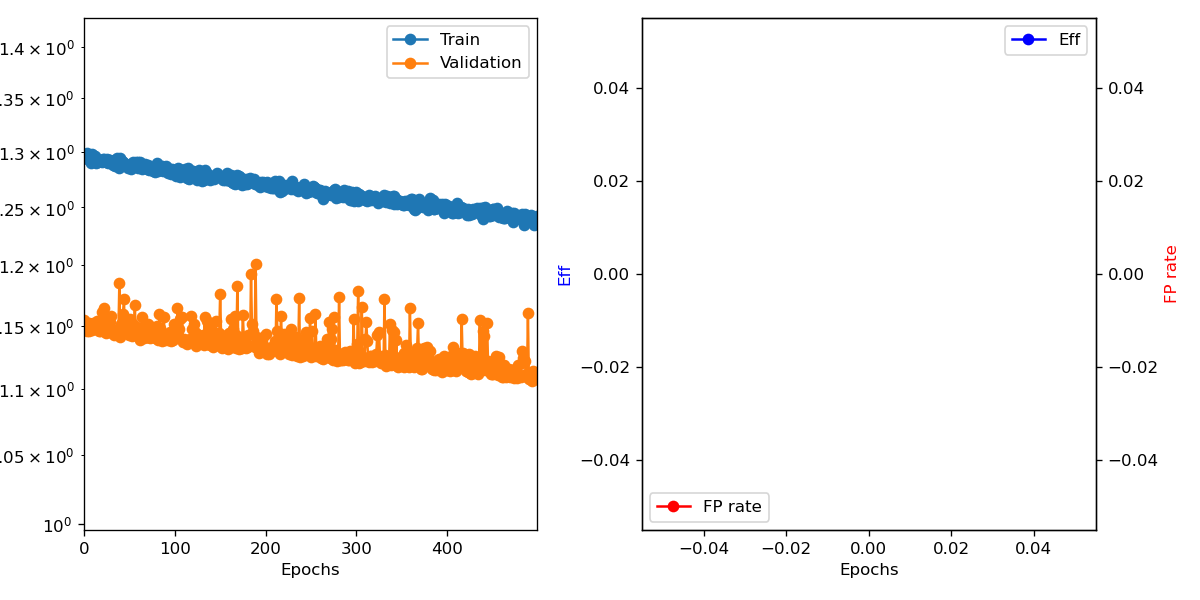

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Number of batches: train = 1125, val = 125


Epoch 0: train=1.2945, val=1.15476, took 38.165 s


Epoch 1: train=1.29676, val=1.14979, took 38.639 s


Epoch 2: train=1.29433, val=1.15149, took 38.776 s


Epoch 3: train=1.29877, val=1.14611, took 38.834 s


Epoch 4: train=1.29616, val=1.14855, took 38.823 s


Epoch 5: train=1.29211, val=1.15196, took 38.7 s


Epoch 6: train=1.29534, val=1.14564, took 39.472 s


Epoch 7: train=1.29601, val=1.14973, took 39.173 s


Epoch 8: train=1.29026, val=1.1504, took 39.317 s


Epoch 9: train=1.29806, val=1.14623, took 39.501 s


Epoch 10: train=1.29375, val=1.15182, took 38.992 s


Epoch 11: train=1.29609, val=1.14798, took 39.406 s


Epoch 12: train=1.29644, val=1.15207, took 39.234 s


Epoch 13: train=1.28981, val=1.15033, took 39.2 s


Epoch 14: train=1.29249, val=1.15402, took 39.021 s


Epoch 15: train=1.29105, val=1.14856, took 39.111 s


Epoch 16: train=1.29158, val=1.15205, took 39.53 s


Epoch 17: train=1.29192, val=1.14567, took 39.327 s


Epoch 18: train=1.29213, val=1.14603, took 38.511 s


Epoch 19: train=1.2914, val=1.14895, took 39.966 s


Epoch 20: train=1.29049, val=1.16115, took 39.314 s


Epoch 21: train=1.29314, val=1.15552, took 38.773 s


Epoch 22: train=1.29345, val=1.16445, took 38.633 s


Epoch 23: train=1.29281, val=1.1453, took 39.674 s


Epoch 24: train=1.29108, val=1.14411, took 40.053 s


Epoch 25: train=1.29305, val=1.15092, took 38.328 s


Epoch 26: train=1.28965, val=1.14639, took 38.433 s


Epoch 27: train=1.29063, val=1.14698, took 38.43 s


Epoch 28: train=1.29253, val=1.1447, took 38.456 s


Epoch 29: train=1.2929, val=1.15313, took 38.925 s


Epoch 30: train=1.29089, val=1.15808, took 38.885 s


Epoch 31: train=1.29178, val=1.14739, took 38.96 s


Epoch 32: train=1.28816, val=1.1445, took 39.161 s


Epoch 33: train=1.29268, val=1.14282, took 39.05 s


Epoch 34: train=1.28744, val=1.14583, took 39.244 s


Epoch 35: train=1.28883, val=1.1443, took 45.273 s


Epoch 36: train=1.29392, val=1.14343, took 40.761 s


Epoch 37: train=1.28669, val=1.14218, took 40.028 s


Epoch 38: train=1.29193, val=1.14681, took 38.927 s


Epoch 39: train=1.28544, val=1.18524, took 38.543 s


Epoch 40: train=1.29435, val=1.14107, took 38.857 s


Epoch 41: train=1.28736, val=1.15136, took 38.518 s


Epoch 42: train=1.29136, val=1.14715, took 38.86 s


Epoch 43: train=1.29037, val=1.15973, took 38.628 s


Epoch 44: train=1.29025, val=1.17215, took 38.784 s


Epoch 45: train=1.28899, val=1.1462, took 38.909 s


Epoch 46: train=1.28781, val=1.14791, took 38.499 s


Epoch 47: train=1.28699, val=1.14936, took 38.55 s


Epoch 48: train=1.28744, val=1.14462, took 38.838 s


Epoch 49: train=1.28499, val=1.14377, took 38.977 s


Epoch 50: train=1.28649, val=1.14259, took 38.776 s


Epoch 51: train=1.2885, val=1.15586, took 38.624 s


Epoch 52: train=1.28456, val=1.14363, took 38.758 s


Epoch 53: train=1.28842, val=1.14149, took 38.951 s


Epoch 54: train=1.29032, val=1.15167, took 38.721 s


Epoch 55: train=1.28699, val=1.14329, took 38.45 s


Epoch 56: train=1.28907, val=1.16705, took 38.352 s


Epoch 57: train=1.29115, val=1.14453, took 38.594 s


Epoch 58: train=1.28576, val=1.14893, took 38.39 s


Epoch 59: train=1.28526, val=1.14268, took 38.433 s


Epoch 60: train=1.29068, val=1.14416, took 38.553 s


Epoch 61: train=1.28639, val=1.14222, took 38.594 s


Epoch 62: train=1.29069, val=1.13878, took 39.103 s


Epoch 63: train=1.28861, val=1.14456, took 39.022 s


Epoch 64: train=1.28446, val=1.15727, took 38.513 s


Epoch 65: train=1.28826, val=1.14114, took 39.162 s


Epoch 66: train=1.2873, val=1.14049, took 39.081 s


Epoch 67: train=1.28905, val=1.14608, took 38.673 s


Epoch 68: train=1.28576, val=1.14305, took 38.443 s


Epoch 69: train=1.28448, val=1.1406, took 39.018 s


Epoch 70: train=1.28789, val=1.15148, took 39.003 s


Epoch 71: train=1.28582, val=1.14111, took 38.891 s


Epoch 72: train=1.28368, val=1.14076, took 38.413 s


Epoch 73: train=1.28532, val=1.1399, took 38.742 s


Epoch 74: train=1.28453, val=1.14862, took 38.568 s


Epoch 75: train=1.28548, val=1.14864, took 38.703 s


Epoch 76: train=1.28247, val=1.14364, took 38.498 s


Epoch 77: train=1.28529, val=1.14246, took 38.735 s


Epoch 78: train=1.28195, val=1.13988, took 38.464 s


Epoch 79: train=1.28487, val=1.14174, took 39.702 s


Epoch 80: train=1.28986, val=1.15005, took 39.594 s


Epoch 81: train=1.28222, val=1.14268, took 38.754 s


Epoch 82: train=1.28527, val=1.13831, took 39.164 s


Epoch 83: train=1.28523, val=1.15988, took 38.973 s


Epoch 84: train=1.28461, val=1.1479, took 38.709 s


Epoch 85: train=1.28598, val=1.14115, took 38.705 s


Epoch 86: train=1.28688, val=1.13781, took 38.726 s


Epoch 87: train=1.28232, val=1.14089, took 38.463 s


Epoch 88: train=1.28656, val=1.157, took 38.858 s


Epoch 89: train=1.28291, val=1.13845, took 39.365 s


Epoch 90: train=1.2875, val=1.14297, took 38.613 s


Epoch 91: train=1.28309, val=1.13896, took 38.626 s


Epoch 92: train=1.2833, val=1.14247, took 38.95 s


Epoch 93: train=1.28045, val=1.13842, took 39.054 s


Epoch 94: train=1.28473, val=1.13985, took 38.737 s


Epoch 95: train=1.28457, val=1.14526, took 39.094 s


Epoch 96: train=1.28019, val=1.13779, took 38.614 s


Epoch 97: train=1.28418, val=1.14078, took 38.749 s


Epoch 98: train=1.28048, val=1.13889, took 38.823 s


Epoch 99: train=1.28356, val=1.15137, took 39.092 s


Epoch 100: train=1.2834, val=1.13985, took 38.946 s


Epoch 101: train=1.2778, val=1.14107, took 38.946 s


Epoch 102: train=1.28058, val=1.1421, took 38.913 s


Epoch 103: train=1.2814, val=1.16449, took 39.039 s


Epoch 104: train=1.28485, val=1.14742, took 38.825 s


Epoch 105: train=1.28414, val=1.14706, took 38.424 s


Epoch 106: train=1.27705, val=1.15511, took 38.661 s


Epoch 107: train=1.28038, val=1.15685, took 38.346 s


Epoch 108: train=1.28217, val=1.15679, took 38.52 s


Epoch 109: train=1.28179, val=1.13664, took 38.572 s


Epoch 110: train=1.281, val=1.13965, took 38.324 s


Epoch 111: train=1.28415, val=1.13734, took 38.405 s


Epoch 112: train=1.28034, val=1.13787, took 38.468 s


Epoch 113: train=1.27668, val=1.13505, took 38.431 s


Epoch 114: train=1.28358, val=1.13875, took 39.443 s


Epoch 115: train=1.28533, val=1.1366, took 40.474 s


Epoch 116: train=1.27559, val=1.13797, took 38.388 s


Epoch 117: train=1.27742, val=1.13918, took 39.753 s


Epoch 118: train=1.27949, val=1.15821, took 39.655 s


Epoch 119: train=1.28272, val=1.14755, took 38.5 s


Epoch 120: train=1.28247, val=1.13827, took 38.544 s


Epoch 121: train=1.27886, val=1.15115, took 38.625 s


Epoch 122: train=1.28068, val=1.1447, took 38.808 s


Epoch 123: train=1.27827, val=1.13397, took 39.024 s


Epoch 124: train=1.28073, val=1.13806, took 38.396 s


Epoch 125: train=1.27469, val=1.14328, took 39.053 s


Epoch 126: train=1.27565, val=1.1364, took 38.339 s


Epoch 127: train=1.28307, val=1.13893, took 38.429 s


Epoch 128: train=1.2761, val=1.13835, took 38.796 s


Epoch 129: train=1.2769, val=1.1366, took 38.526 s


Epoch 130: train=1.27366, val=1.13599, took 39.096 s


Epoch 131: train=1.28161, val=1.14266, took 39.8 s


Epoch 132: train=1.27419, val=1.13429, took 38.658 s


Epoch 133: train=1.28306, val=1.15748, took 38.51 s


Epoch 134: train=1.28153, val=1.13899, took 38.375 s


Epoch 135: train=1.27745, val=1.15355, took 38.547 s


Epoch 136: train=1.27974, val=1.14308, took 38.467 s


Epoch 137: train=1.27704, val=1.13519, took 38.837 s


Epoch 138: train=1.27614, val=1.13721, took 38.29 s


Epoch 139: train=1.27433, val=1.13473, took 38.587 s


Epoch 140: train=1.27831, val=1.13645, took 38.482 s


Epoch 141: train=1.27624, val=1.14648, took 38.98 s


Epoch 142: train=1.27668, val=1.13262, took 38.657 s


Epoch 143: train=1.27559, val=1.13518, took 38.842 s


Epoch 144: train=1.27915, val=1.13438, took 38.563 s


Epoch 145: train=1.27865, val=1.15414, took 38.544 s


Epoch 146: train=1.27796, val=1.13481, took 38.463 s


Epoch 147: train=1.28057, val=1.13798, took 38.513 s


Epoch 148: train=1.27759, val=1.14284, took 38.363 s


Epoch 149: train=1.27833, val=1.14406, took 38.605 s


Epoch 150: train=1.27692, val=1.17582, took 38.828 s


Epoch 151: train=1.27842, val=1.14242, took 38.605 s


Epoch 152: train=1.27687, val=1.13245, took 38.504 s


Epoch 153: train=1.274, val=1.1326, took 38.526 s


Epoch 154: train=1.27616, val=1.1338, took 38.215 s


Epoch 155: train=1.27427, val=1.14137, took 39.344 s


Epoch 156: train=1.27702, val=1.13519, took 38.697 s


Epoch 157: train=1.27453, val=1.13387, took 38.28 s


Epoch 158: train=1.28074, val=1.13572, took 38.24 s


Epoch 159: train=1.27766, val=1.13162, took 38.458 s


Epoch 160: train=1.27726, val=1.14391, took 38.776 s


Epoch 161: train=1.27331, val=1.13936, took 38.715 s


Epoch 162: train=1.27911, val=1.15557, took 38.517 s


Epoch 163: train=1.27289, val=1.13283, took 38.972 s


Epoch 164: train=1.27162, val=1.14738, took 38.662 s


Epoch 165: train=1.27604, val=1.13778, took 38.671 s


Epoch 166: train=1.27098, val=1.15824, took 38.77 s


Epoch 167: train=1.27682, val=1.132, took 38.307 s


Epoch 168: train=1.27213, val=1.14277, took 38.481 s


Epoch 169: train=1.27867, val=1.18286, took 38.829 s


Epoch 170: train=1.277, val=1.13348, took 38.891 s


Epoch 171: train=1.27842, val=1.13102, took 38.572 s


Epoch 172: train=1.27757, val=1.14003, took 38.702 s


Epoch 173: train=1.27319, val=1.13247, took 38.888 s


Epoch 174: train=1.27021, val=1.1319, took 39.059 s


Epoch 175: train=1.27071, val=1.15869, took 39.007 s


Epoch 176: train=1.27433, val=1.14109, took 38.38 s


Epoch 177: train=1.27079, val=1.13658, took 38.535 s


Epoch 178: train=1.27532, val=1.13234, took 38.687 s


Epoch 179: train=1.27316, val=1.13403, took 38.934 s


Epoch 180: train=1.27093, val=1.13311, took 38.338 s


Epoch 181: train=1.27172, val=1.14258, took 38.291 s


Epoch 182: train=1.27515, val=1.13344, took 40.08 s


Epoch 183: train=1.27644, val=1.13384, took 38.758 s


Epoch 184: train=1.27346, val=1.19246, took 39.343 s


Epoch 185: train=1.27341, val=1.15128, took 38.854 s


Epoch 186: train=1.27385, val=1.14564, took 40.009 s


Epoch 187: train=1.27526, val=1.14242, took 38.809 s


Epoch 188: train=1.27052, val=1.13307, took 38.73 s


Epoch 189: train=1.27259, val=1.20126, took 38.968 s


Epoch 190: train=1.27233, val=1.1408, took 39.078 s


Epoch 191: train=1.27072, val=1.13197, took 38.826 s


Epoch 192: train=1.26951, val=1.1366, took 39.08 s


Epoch 193: train=1.27195, val=1.12799, took 38.339 s


Epoch 194: train=1.26846, val=1.13079, took 38.365 s


Epoch 195: train=1.27236, val=1.132, took 38.399 s


Epoch 196: train=1.27215, val=1.13678, took 38.357 s


Epoch 197: train=1.2728, val=1.14109, took 38.404 s


Epoch 198: train=1.27158, val=1.1296, took 38.489 s


Epoch 199: train=1.26907, val=1.13325, took 38.442 s


Epoch 200: train=1.27117, val=1.14337, took 38.806 s


Epoch 201: train=1.27173, val=1.13055, took 38.807 s


Epoch 202: train=1.2728, val=1.12699, took 38.285 s


Epoch 203: train=1.26817, val=1.1283, took 38.65 s


Epoch 204: train=1.27058, val=1.12693, took 38.466 s


Epoch 205: train=1.26812, val=1.13193, took 38.728 s


Epoch 206: train=1.26764, val=1.1304, took 38.525 s


Epoch 207: train=1.27198, val=1.12958, took 38.281 s


Epoch 208: train=1.26722, val=1.13352, took 38.441 s


Epoch 209: train=1.26722, val=1.13014, took 38.415 s


Epoch 210: train=1.27339, val=1.13784, took 38.448 s


Epoch 211: train=1.26821, val=1.13079, took 38.457 s


Epoch 212: train=1.26717, val=1.17158, took 38.94 s


Epoch 213: train=1.26919, val=1.1456, took 38.633 s


Epoch 214: train=1.26917, val=1.13166, took 38.745 s


Epoch 215: train=1.27329, val=1.13041, took 38.661 s


Epoch 216: train=1.26351, val=1.12717, took 38.637 s


Epoch 217: train=1.27119, val=1.15816, took 39.046 s


Epoch 218: train=1.2646, val=1.13895, took 38.747 s


Epoch 219: train=1.26648, val=1.13777, took 38.584 s


Epoch 220: train=1.26673, val=1.1435, took 38.84 s


Epoch 221: train=1.26937, val=1.12978, took 38.913 s


Epoch 222: train=1.26952, val=1.12932, took 38.519 s


Epoch 223: train=1.26748, val=1.13535, took 38.316 s


Epoch 224: train=1.26808, val=1.13103, took 38.76 s


Epoch 225: train=1.26774, val=1.14115, took 38.878 s


Epoch 226: train=1.26923, val=1.12693, took 38.761 s


Epoch 227: train=1.26946, val=1.1444, took 38.498 s


Epoch 228: train=1.26653, val=1.14723, took 38.629 s


Epoch 229: train=1.27322, val=1.12673, took 38.382 s


Epoch 230: train=1.26783, val=1.12713, took 38.56 s


Epoch 231: train=1.26628, val=1.12911, took 38.802 s


Epoch 232: train=1.26741, val=1.12741, took 38.633 s


Epoch 233: train=1.26804, val=1.13517, took 38.744 s


Epoch 234: train=1.26649, val=1.1406, took 38.81 s


Epoch 235: train=1.2677, val=1.12552, took 38.327 s


Epoch 236: train=1.26465, val=1.12782, took 38.3 s


Epoch 237: train=1.26666, val=1.17257, took 38.573 s


Epoch 238: train=1.26708, val=1.12522, took 38.605 s


Epoch 239: train=1.26803, val=1.12776, took 38.782 s


Epoch 240: train=1.26519, val=1.13085, took 38.564 s


Epoch 241: train=1.267, val=1.1261, took 38.45 s


Epoch 242: train=1.27043, val=1.1339, took 38.438 s


Epoch 243: train=1.26479, val=1.13284, took 38.517 s


Epoch 244: train=1.26509, val=1.14038, took 38.51 s


Epoch 245: train=1.26275, val=1.14458, took 38.762 s


Epoch 246: train=1.26519, val=1.13074, took 38.283 s


Epoch 247: train=1.2638, val=1.12847, took 38.089 s


Epoch 248: train=1.26454, val=1.12871, took 38.862 s


Epoch 249: train=1.26584, val=1.15664, took 38.831 s


Epoch 250: train=1.26449, val=1.12454, took 40.651 s


Epoch 251: train=1.2643, val=1.14564, took 39.115 s


Epoch 252: train=1.26883, val=1.1272, took 38.708 s


Epoch 253: train=1.26794, val=1.13169, took 38.587 s


Epoch 254: train=1.2676, val=1.12647, took 38.828 s


Epoch 255: train=1.26686, val=1.15983, took 38.797 s


Epoch 256: train=1.26332, val=1.12568, took 38.399 s


Epoch 257: train=1.26307, val=1.12747, took 38.64 s


Epoch 258: train=1.26472, val=1.12992, took 38.457 s


Epoch 259: train=1.26525, val=1.13185, took 40.658 s


Epoch 260: train=1.26532, val=1.13406, took 39.162 s


Epoch 261: train=1.26178, val=1.1241, took 39.158 s


Epoch 262: train=1.26008, val=1.12534, took 38.45 s


Epoch 263: train=1.2577, val=1.123, took 38.834 s


Epoch 264: train=1.2641, val=1.13049, took 39.354 s


Epoch 265: train=1.26474, val=1.12583, took 38.729 s


Epoch 266: train=1.2621, val=1.12982, took 38.656 s


Epoch 267: train=1.26158, val=1.12996, took 40.253 s


Epoch 268: train=1.26085, val=1.1396, took 38.481 s


Epoch 269: train=1.26166, val=1.1307, took 39.898 s


Epoch 270: train=1.26321, val=1.15289, took 39.151 s


Epoch 271: train=1.26155, val=1.12408, took 38.806 s


Epoch 272: train=1.26096, val=1.13917, took 38.952 s


Epoch 273: train=1.26403, val=1.1474, took 40.064 s


Epoch 274: train=1.26415, val=1.12236, took 44.397 s


Epoch 275: train=1.26514, val=1.15715, took 40.616 s


Epoch 276: train=1.26614, val=1.13073, took 38.422 s


Epoch 277: train=1.26328, val=1.12662, took 38.135 s


Epoch 278: train=1.25851, val=1.12562, took 39.026 s


Epoch 279: train=1.26491, val=1.12184, took 38.37 s


Epoch 280: train=1.26154, val=1.12839, took 38.6 s


Epoch 281: train=1.25957, val=1.17319, took 41.4 s


Epoch 282: train=1.26131, val=1.1225, took 39.365 s


Epoch 283: train=1.26142, val=1.12239, took 38.582 s


Epoch 284: train=1.2624, val=1.12451, took 38.188 s


Epoch 285: train=1.25911, val=1.12248, took 38.587 s


Epoch 286: train=1.26552, val=1.12669, took 38.53 s


Epoch 287: train=1.26343, val=1.12577, took 38.525 s


Epoch 288: train=1.26315, val=1.12927, took 39.286 s


Epoch 289: train=1.25969, val=1.12379, took 39.233 s


Epoch 290: train=1.2606, val=1.12642, took 38.211 s


Epoch 291: train=1.26489, val=1.1228, took 38.075 s


Epoch 292: train=1.25911, val=1.12221, took 38.341 s


Epoch 293: train=1.2568, val=1.12967, took 39.22 s


Epoch 294: train=1.25634, val=1.12528, took 38.425 s


Epoch 295: train=1.26347, val=1.12673, took 38.795 s


Epoch 296: train=1.26124, val=1.12272, took 38.989 s


Epoch 297: train=1.25539, val=1.15572, took 38.759 s


Epoch 298: train=1.26088, val=1.12001, took 38.077 s


Epoch 299: train=1.25794, val=1.12258, took 38.336 s


Epoch 300: train=1.26362, val=1.12432, took 38.362 s


Epoch 301: train=1.25997, val=1.13528, took 38.749 s


Epoch 302: train=1.25586, val=1.17818, took 39.559 s


Epoch 303: train=1.26201, val=1.12035, took 40.354 s


Epoch 304: train=1.26092, val=1.12125, took 41.191 s


Epoch 305: train=1.25948, val=1.12233, took 41.102 s


Epoch 306: train=1.25883, val=1.16542, took 39.505 s


Epoch 307: train=1.25942, val=1.12195, took 41.375 s


Epoch 308: train=1.25913, val=1.12172, took 39.525 s


Epoch 309: train=1.25641, val=1.12411, took 39.773 s


Epoch 310: train=1.25957, val=1.13904, took 38.751 s


Epoch 311: train=1.25837, val=1.15275, took 38.629 s


Epoch 312: train=1.25547, val=1.13762, took 40.204 s


Epoch 313: train=1.25714, val=1.12322, took 38.237 s


Epoch 314: train=1.2606, val=1.1208, took 38.655 s


Epoch 315: train=1.2605, val=1.12538, took 39.402 s


Epoch 316: train=1.2566, val=1.12556, took 38.664 s


Epoch 317: train=1.25778, val=1.12125, took 38.626 s


Epoch 318: train=1.25804, val=1.124, took 38.356 s


Epoch 319: train=1.2582, val=1.1227, took 38.704 s


Epoch 320: train=1.25916, val=1.12472, took 38.445 s


Epoch 321: train=1.25978, val=1.12211, took 38.658 s


Epoch 322: train=1.25749, val=1.12759, took 39.272 s


Epoch 323: train=1.25802, val=1.14233, took 39.474 s


Epoch 324: train=1.25392, val=1.12545, took 39.837 s


Epoch 325: train=1.2573, val=1.1452, took 38.838 s


Epoch 326: train=1.25585, val=1.1259, took 38.395 s


Epoch 327: train=1.25829, val=1.1199, took 38.045 s


Epoch 328: train=1.2572, val=1.12187, took 38.218 s


Epoch 329: train=1.25614, val=1.12106, took 38.082 s


Epoch 330: train=1.26062, val=1.11995, took 38.367 s


Epoch 331: train=1.25812, val=1.17201, took 38.63 s


Epoch 332: train=1.25798, val=1.12635, took 43.117 s


Epoch 333: train=1.25504, val=1.11784, took 43.709 s


Epoch 334: train=1.25976, val=1.11979, took 40.559 s


Epoch 335: train=1.25923, val=1.12033, took 42.693 s


Epoch 336: train=1.25918, val=1.11992, took 38.574 s


Epoch 337: train=1.25378, val=1.1514, took 39.112 s


Epoch 338: train=1.25636, val=1.11879, took 40.089 s


Epoch 339: train=1.25923, val=1.14673, took 38.775 s


Epoch 340: train=1.26054, val=1.11913, took 39.333 s


Epoch 341: train=1.26054, val=1.14475, took 38.05 s


Epoch 342: train=1.25314, val=1.12149, took 38.527 s


Epoch 343: train=1.25707, val=1.11857, took 38.93 s


Epoch 344: train=1.25784, val=1.13809, took 38.177 s


Epoch 345: train=1.25272, val=1.11861, took 38.295 s


Epoch 346: train=1.25527, val=1.117, took 38.738 s


Epoch 347: train=1.25567, val=1.11902, took 38.674 s


Epoch 348: train=1.2559, val=1.11843, took 38.73 s


Epoch 349: train=1.25293, val=1.1217, took 38.261 s


Epoch 350: train=1.25336, val=1.12582, took 38.15 s


Epoch 351: train=1.2524, val=1.11873, took 38.556 s


Epoch 352: train=1.2533, val=1.1174, took 38.662 s


Epoch 353: train=1.25198, val=1.1278, took 39.065 s


Epoch 354: train=1.25589, val=1.12755, took 38.624 s


Epoch 355: train=1.25382, val=1.13439, took 38.429 s


Epoch 356: train=1.25543, val=1.12499, took 38.923 s


Epoch 357: train=1.25437, val=1.11926, took 38.957 s


Epoch 358: train=1.25197, val=1.1173, took 38.346 s


Epoch 359: train=1.25526, val=1.16467, took 39.611 s


Epoch 360: train=1.25715, val=1.12566, took 38.404 s


Epoch 361: train=1.25738, val=1.12516, took 39.007 s


Epoch 362: train=1.25579, val=1.11912, took 38.924 s


Epoch 363: train=1.25463, val=1.11689, took 38.942 s


Epoch 364: train=1.24892, val=1.12076, took 38.611 s


Epoch 365: train=1.2481, val=1.11931, took 38.579 s


Epoch 366: train=1.25397, val=1.12861, took 39.661 s


Epoch 367: train=1.24969, val=1.13238, took 39.914 s


Epoch 368: train=1.25184, val=1.15232, took 38.65 s


Epoch 369: train=1.25772, val=1.11991, took 39.045 s


Epoch 370: train=1.25417, val=1.11935, took 38.83 s


Epoch 371: train=1.2519, val=1.1158, took 39.242 s


Epoch 372: train=1.25397, val=1.1152, took 38.932 s


Epoch 373: train=1.25057, val=1.11989, took 38.546 s


Epoch 374: train=1.25291, val=1.1272, took 38.587 s


Epoch 375: train=1.25141, val=1.13201, took 38.422 s


Epoch 376: train=1.25021, val=1.11988, took 38.596 s


Epoch 377: train=1.25227, val=1.1283, took 38.533 s


Epoch 378: train=1.25406, val=1.13278, took 39.594 s


Epoch 379: train=1.24812, val=1.11908, took 38.642 s


Epoch 380: train=1.2494, val=1.12324, took 38.56 s


Epoch 381: train=1.25829, val=1.12958, took 38.623 s


Epoch 382: train=1.25248, val=1.11744, took 38.417 s


Epoch 383: train=1.25075, val=1.11542, took 38.819 s


Epoch 384: train=1.25681, val=1.11739, took 38.413 s


Epoch 385: train=1.24864, val=1.12046, took 38.397 s


Epoch 386: train=1.2486, val=1.11455, took 38.236 s


Epoch 387: train=1.24985, val=1.11749, took 38.47 s


Epoch 388: train=1.25098, val=1.11451, took 38.765 s


Epoch 389: train=1.24968, val=1.11698, took 40.567 s


Epoch 390: train=1.24986, val=1.12292, took 38.587 s


Epoch 391: train=1.25343, val=1.12339, took 38.891 s


Epoch 392: train=1.25059, val=1.1154, took 38.735 s


Epoch 393: train=1.25117, val=1.11782, took 38.771 s


Epoch 394: train=1.2527, val=1.11321, took 38.454 s


Epoch 395: train=1.25126, val=1.12028, took 40.914 s


Epoch 396: train=1.24534, val=1.1254, took 38.24 s


Epoch 397: train=1.24976, val=1.11825, took 38.473 s


Epoch 398: train=1.25299, val=1.11578, took 41.411 s


Epoch 399: train=1.25224, val=1.11451, took 38.782 s


Epoch 400: train=1.25056, val=1.11763, took 40.542 s


Epoch 401: train=1.24765, val=1.11498, took 38.242 s


Epoch 402: train=1.2517, val=1.11869, took 38.486 s


Epoch 403: train=1.24937, val=1.11385, took 38.538 s


Epoch 404: train=1.24722, val=1.1261, took 38.763 s


Epoch 405: train=1.24496, val=1.11634, took 38.47 s


Epoch 406: train=1.2487, val=1.11475, took 38.627 s


Epoch 407: train=1.24551, val=1.13316, took 40.718 s


Epoch 408: train=1.24955, val=1.11777, took 38.52 s


Epoch 409: train=1.24589, val=1.1263, took 38.995 s


Epoch 410: train=1.24727, val=1.11425, took 38.798 s


Epoch 411: train=1.25417, val=1.11942, took 38.63 s


Epoch 412: train=1.24486, val=1.12324, took 38.938 s


Epoch 413: train=1.24899, val=1.11764, took 39.476 s


Epoch 414: train=1.2459, val=1.12819, took 38.263 s


Epoch 415: train=1.25035, val=1.11956, took 38.428 s


Epoch 416: train=1.24882, val=1.15553, took 38.977 s


Epoch 417: train=1.24965, val=1.12403, took 38.576 s


Epoch 418: train=1.24767, val=1.12796, took 40.364 s


Epoch 419: train=1.24866, val=1.11819, took 38.387 s


Epoch 420: train=1.2461, val=1.12533, took 38.719 s


Epoch 421: train=1.24702, val=1.11371, took 39.16 s


Epoch 422: train=1.24332, val=1.11414, took 39.48 s


Epoch 423: train=1.24846, val=1.11325, took 38.43 s


Epoch 424: train=1.24296, val=1.1271, took 38.377 s


Epoch 425: train=1.24715, val=1.11266, took 38.722 s


Epoch 426: train=1.24664, val=1.11169, took 38.668 s


Epoch 427: train=1.2442, val=1.12119, took 43.263 s


Epoch 428: train=1.24854, val=1.11444, took 39.845 s


Epoch 429: train=1.24519, val=1.11243, took 38.417 s


Epoch 430: train=1.24751, val=1.11464, took 38.594 s


Epoch 431: train=1.24773, val=1.12548, took 38.451 s


Epoch 432: train=1.24704, val=1.11994, took 38.396 s


Epoch 433: train=1.2493, val=1.12283, took 38.173 s


Epoch 434: train=1.24901, val=1.11131, took 38.86 s


Epoch 435: train=1.24684, val=1.11665, took 38.344 s


Epoch 436: train=1.24932, val=1.15471, took 38.82 s


Epoch 437: train=1.24322, val=1.11512, took 40.792 s


Epoch 438: train=1.24979, val=1.11809, took 38.975 s


Epoch 439: train=1.2494, val=1.14557, took 38.463 s


Epoch 440: train=1.23955, val=1.12323, took 38.164 s


Epoch 441: train=1.24352, val=1.14136, took 38.232 s


Epoch 442: train=1.25029, val=1.11455, took 38.263 s


Epoch 443: train=1.24379, val=1.11916, took 38.181 s


Epoch 444: train=1.24436, val=1.15219, took 38.094 s


Epoch 445: train=1.24505, val=1.12171, took 38.279 s


Epoch 446: train=1.24252, val=1.11378, took 38.544 s


Epoch 447: train=1.2426, val=1.121, took 38.349 s


Epoch 448: train=1.24315, val=1.11137, took 38.889 s


Epoch 449: train=1.2432, val=1.11188, took 38.578 s


Epoch 450: train=1.24826, val=1.11199, took 38.164 s


Epoch 451: train=1.24868, val=1.11176, took 38.559 s


Epoch 452: train=1.2432, val=1.12087, took 38.773 s


Epoch 453: train=1.24636, val=1.11303, took 38.796 s


Epoch 454: train=1.24623, val=1.12568, took 38.827 s


Epoch 455: train=1.24966, val=1.11744, took 38.709 s


Epoch 456: train=1.24456, val=1.11063, took 38.445 s


Epoch 457: train=1.24183, val=1.12501, took 38.192 s


Epoch 458: train=1.24424, val=1.11724, took 38.03 s


Epoch 459: train=1.24201, val=1.11152, took 38.366 s


Epoch 460: train=1.2434, val=1.10949, took 38.301 s


Epoch 461: train=1.24091, val=1.10945, took 38.542 s


Epoch 462: train=1.24275, val=1.11577, took 38.569 s


Epoch 463: train=1.24044, val=1.11822, took 39.574 s


Epoch 464: train=1.24082, val=1.11036, took 38.878 s


Epoch 465: train=1.2443, val=1.10899, took 38.607 s


Epoch 466: train=1.24648, val=1.11121, took 38.578 s


Epoch 467: train=1.24229, val=1.11326, took 38.502 s


Epoch 468: train=1.24497, val=1.11514, took 38.913 s


Epoch 469: train=1.24227, val=1.10895, took 38.593 s


Epoch 470: train=1.24247, val=1.10975, took 38.49 s


Epoch 471: train=1.24534, val=1.11105, took 38.12 s


Epoch 472: train=1.23718, val=1.11025, took 38.497 s


Epoch 473: train=1.24467, val=1.11288, took 38.372 s


Epoch 474: train=1.24545, val=1.10864, took 38.253 s


Epoch 475: train=1.24326, val=1.11583, took 38.727 s


Epoch 476: train=1.24194, val=1.11022, took 38.81 s


Epoch 477: train=1.24253, val=1.10825, took 38.658 s


Epoch 478: train=1.24141, val=1.11833, took 38.337 s


Epoch 479: train=1.24064, val=1.11032, took 38.197 s


Epoch 480: train=1.24027, val=1.1104, took 38.276 s


Epoch 481: train=1.24284, val=1.1093, took 38.438 s


Epoch 482: train=1.24465, val=1.12986, took 38.44 s


Epoch 483: train=1.24237, val=1.11991, took 39.43 s


Epoch 484: train=1.24053, val=1.12422, took 38.793 s


Epoch 485: train=1.23434, val=1.12139, took 38.576 s


Epoch 486: train=1.24391, val=1.12187, took 39.18 s


Epoch 487: train=1.23954, val=1.11162, took 38.943 s


Epoch 488: train=1.23984, val=1.10914, took 38.472 s


Epoch 489: train=1.24103, val=1.16026, took 38.77 s


Epoch 490: train=1.24028, val=1.10787, took 37.507 s


Epoch 491: train=1.23978, val=1.11024, took 36.891 s


Epoch 492: train=1.24327, val=1.10752, took 37.469 s


Epoch 493: train=1.23854, val=1.10633, took 36.808 s


Epoch 494: train=1.23925, val=1.1082, took 36.894 s


Epoch 495: train=1.23928, val=1.11389, took 36.794 s


Epoch 496: train=1.23476, val=1.10889, took 36.676 s


Epoch 497: train=1.23677, val=1.11052, took 36.985 s


Epoch 498: train=1.23867, val=1.10735, took 36.831 s


Epoch 499: train=1.24273, val=1.10802, took 36.674 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


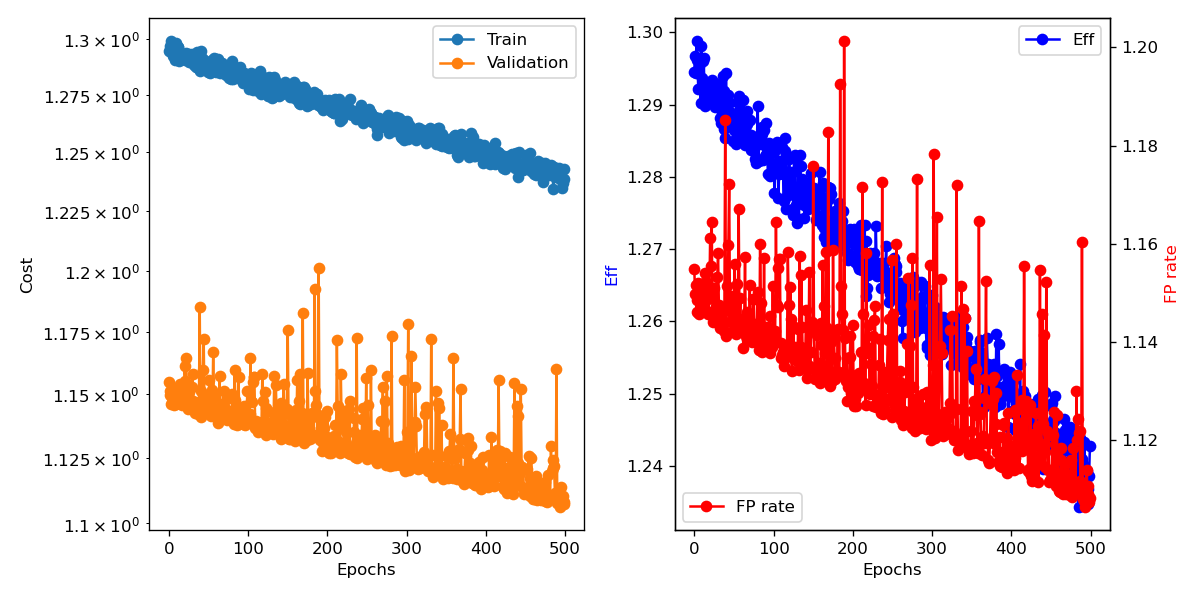

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [21]:
##quit()
